# 1 INICIALIZAÇÃO

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

dadosGerais = pd.read_csv("eleicoes_2006_a_2010.csv")
novoTeste = pd.read_csv("eleicoes_2014.csv")

In [15]:
def rmse_cv(model,x_treino,y_treino):
    rmse= np.sqrt(-cross_val_score(model, x_treino, y_treino, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# 2 PRÉ-PROCESSAMENTO

## 2.1 Normalizando as características

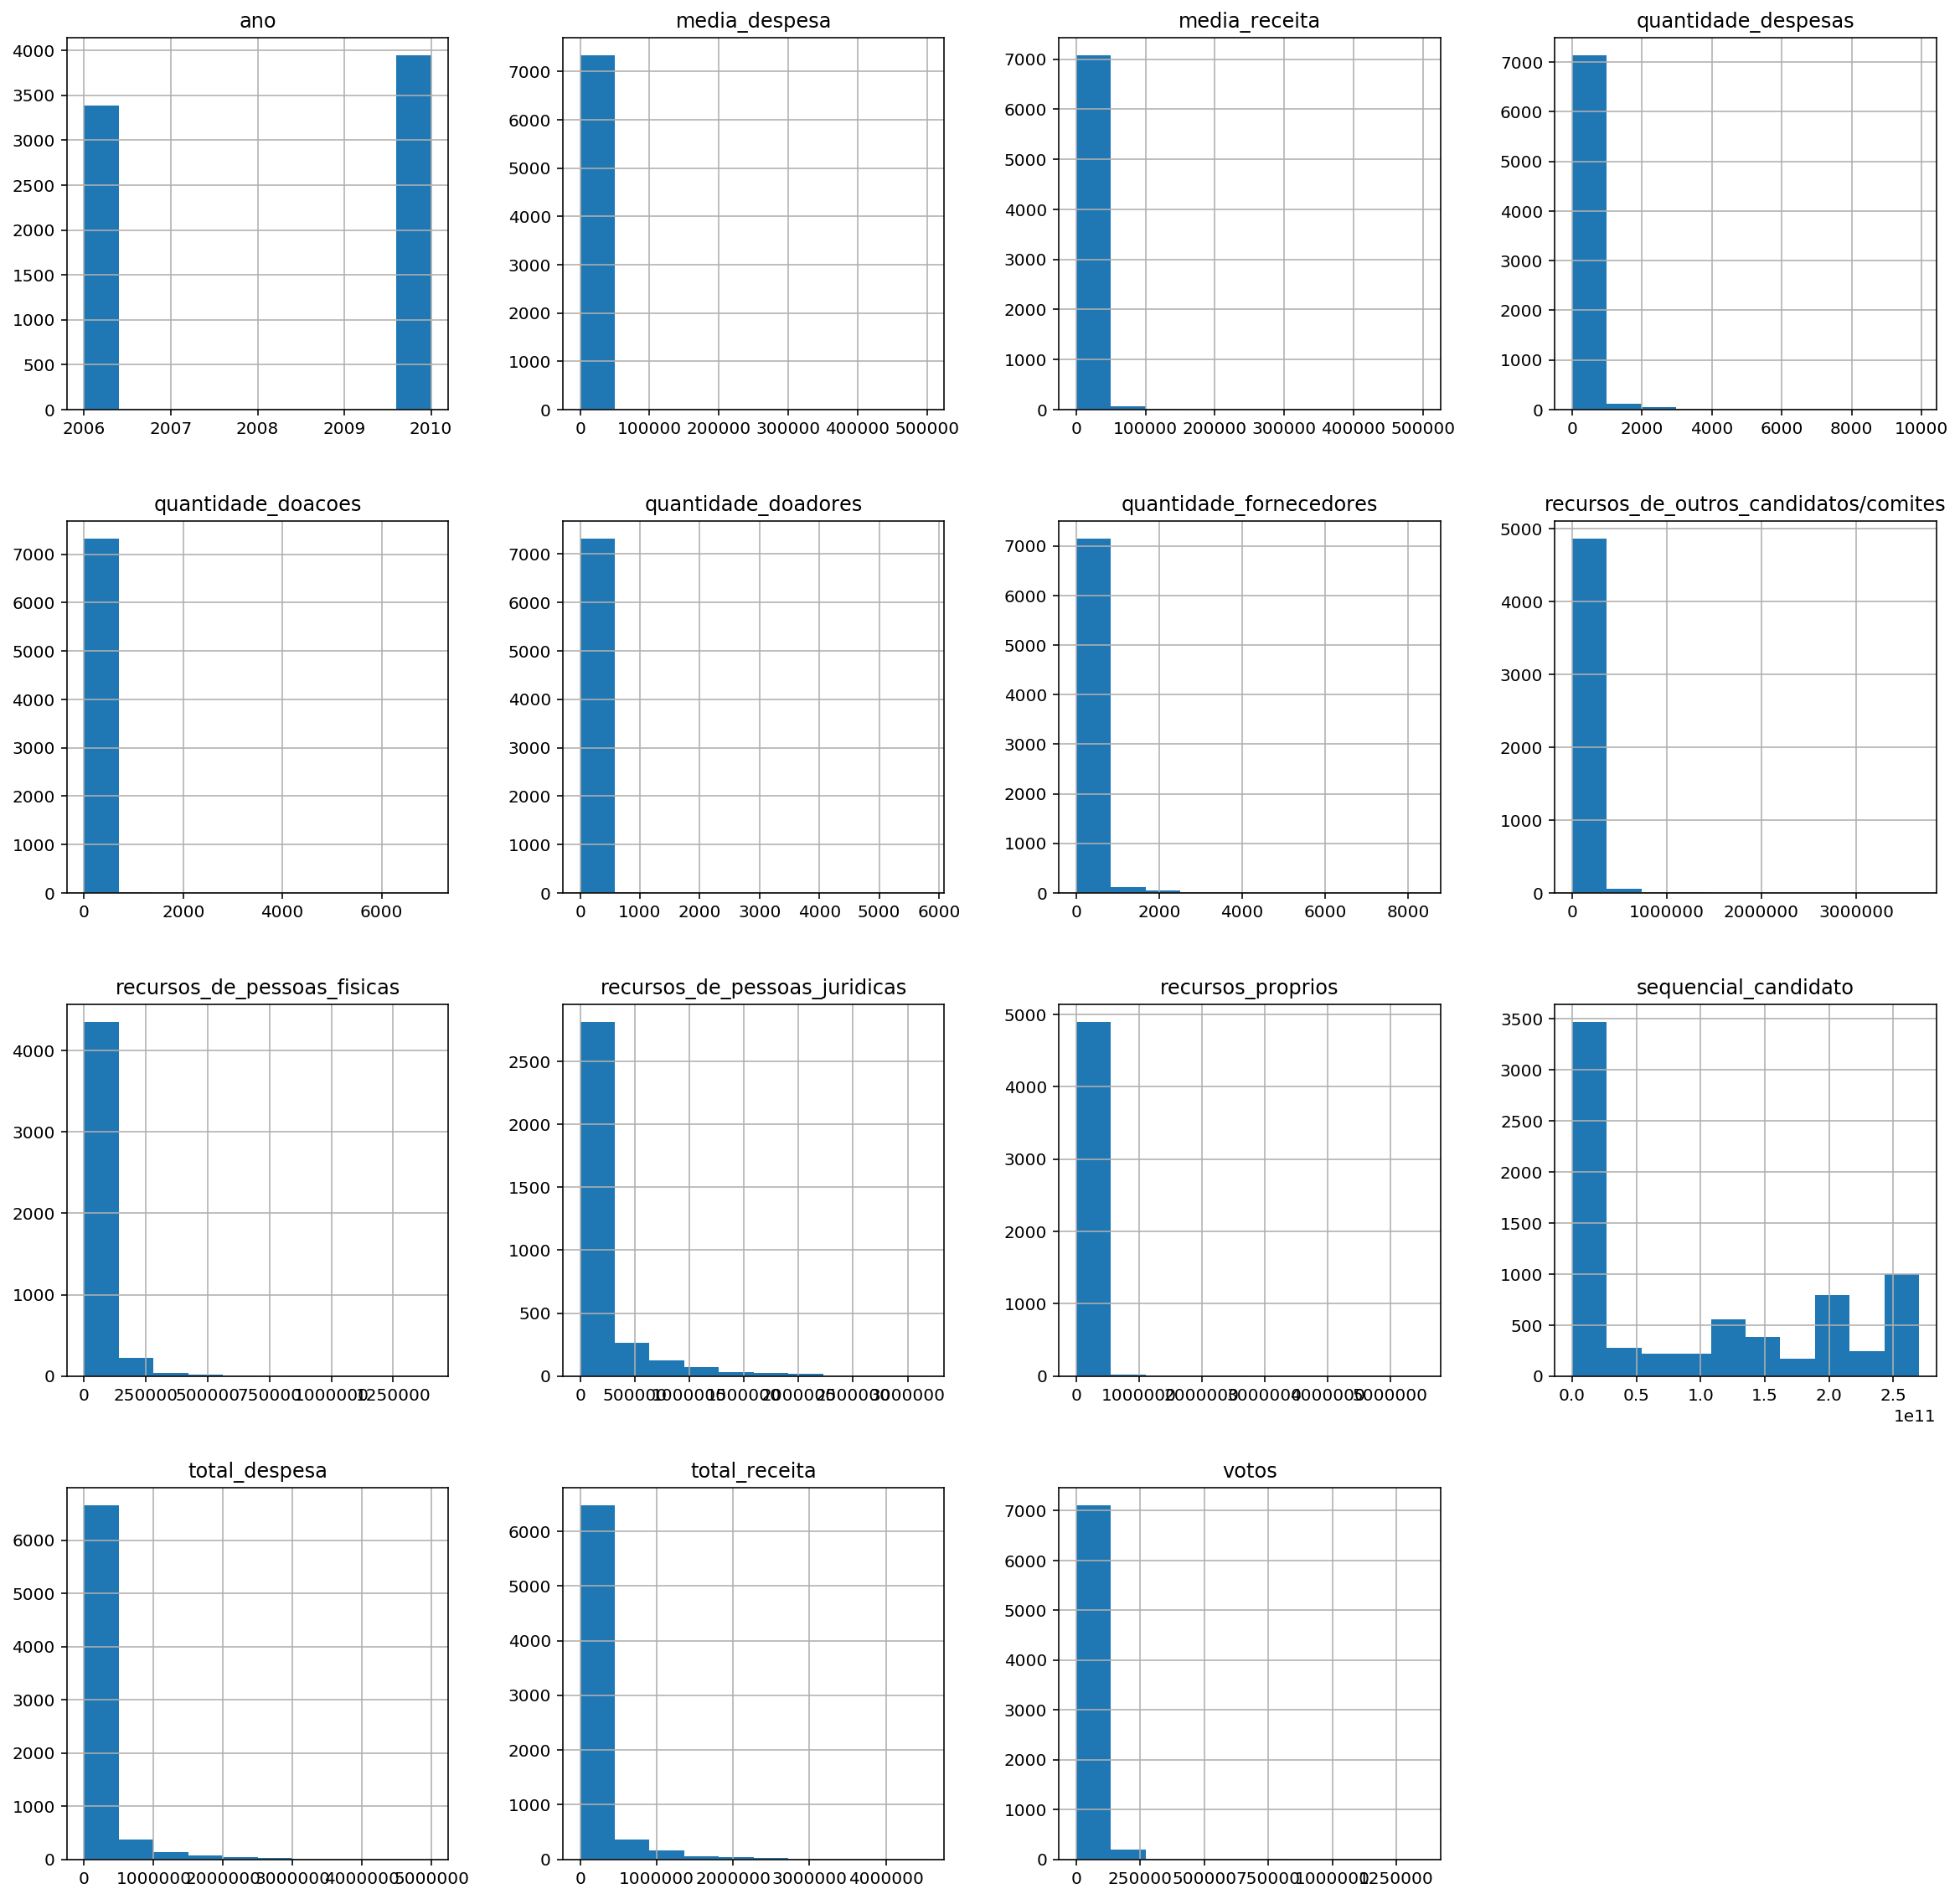

In [16]:
#Analise por meio de histogramas o enviesamento da variável 'votos' com relação ao log+1 dela 
dadosGerais[dadosGerais.dtypes[dadosGerais.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

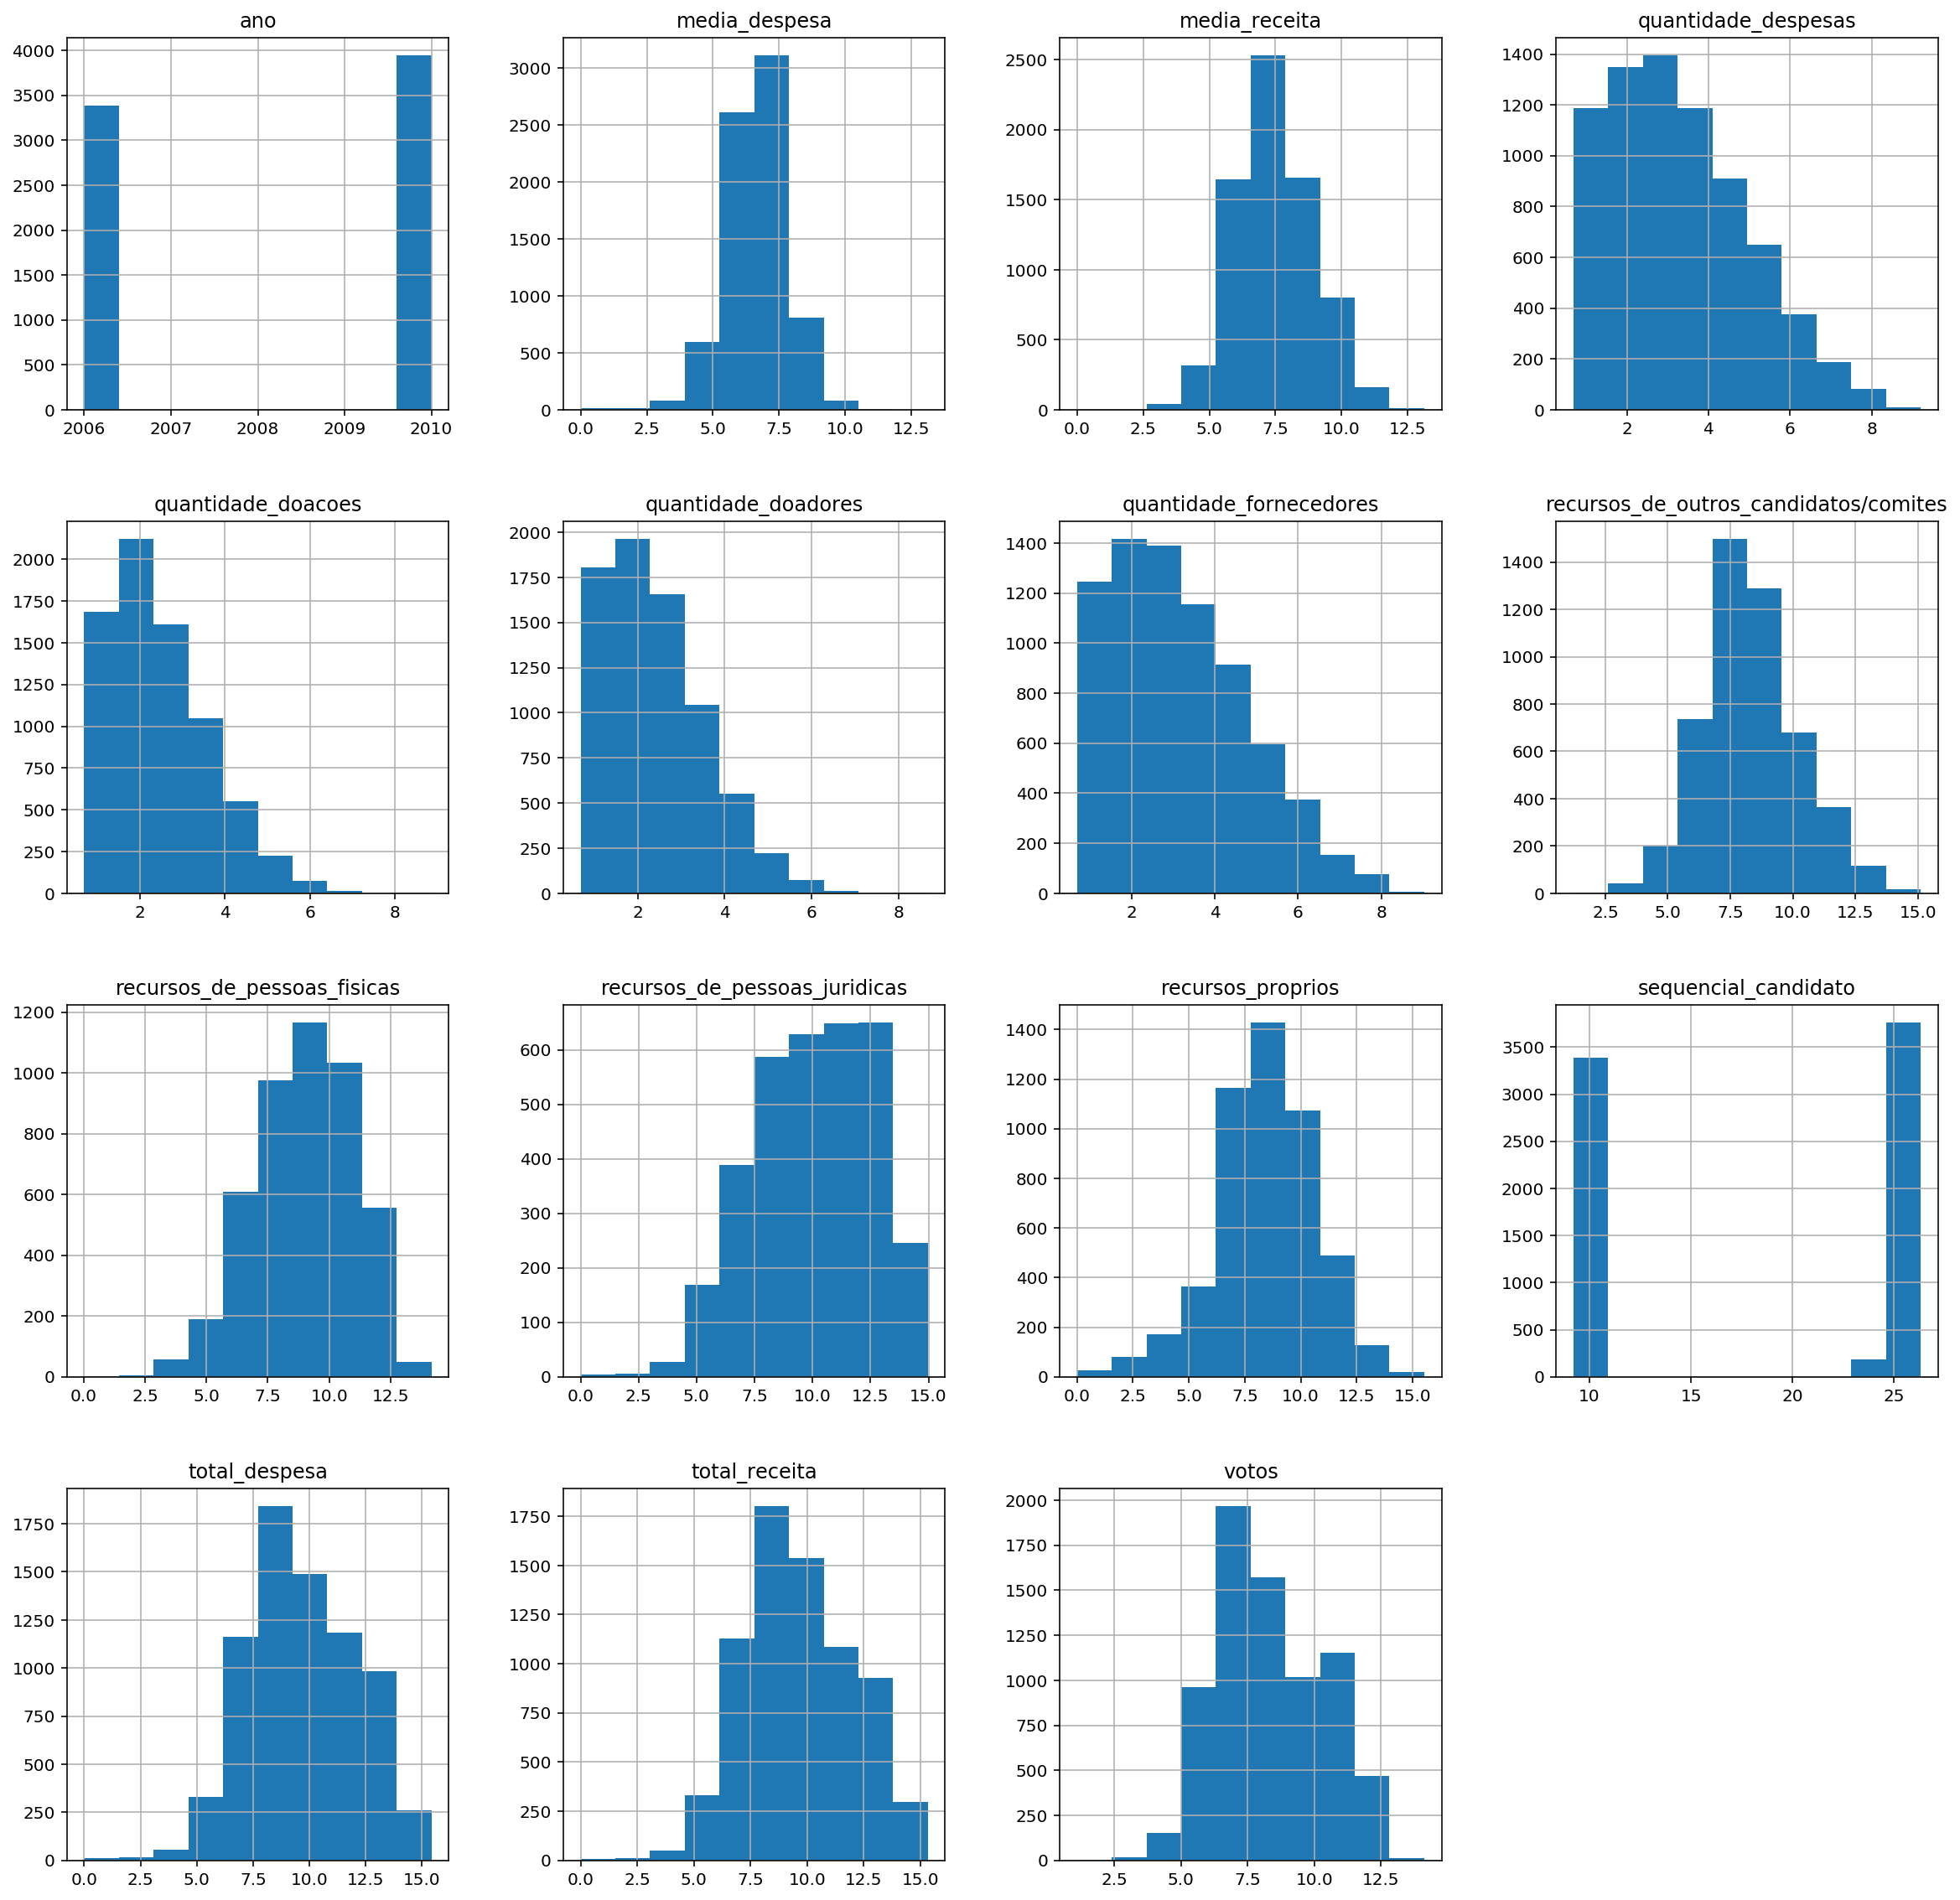

In [17]:
#Nesse momento, todos as variáveis são atualizadas pelo log+1 delas com relação ao nível de skewness delas
numeric_feats = dadosGerais.dtypes[dadosGerais.dtypes != "object"].index

skewed_feats = dadosGerais[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats[1:]

dadosGerais[skewed_feats] = np.log1p(dadosGerais[skewed_feats])

#Também realizado no novo conjunto de teste
numeric_feats = novoTeste.dtypes[novoTeste.dtypes != "object"].index

skewed_feats = novoTeste[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats[1:]

novoTeste[skewed_feats] = np.log1p(novoTeste[skewed_feats])

#Exibição dos dados gerais (treino e teste)
dadosGerais[dadosGerais.dtypes[dadosGerais.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

## 2.3 Alterando variáveis categóricas

In [18]:
#removendo colunas 'nomes' e 'sequencial_candidato' para reduzir dimensões da matriz e por considerar que não são influenciadores
dadosGerais = dadosGerais.drop(["nome"],axis=1)
dadosGerais = dadosGerais.drop(["sequencial_candidato"],axis=1)

novoTeste = novoTeste.drop(["nome_candidato"],axis=1)
novoTeste = novoTeste.drop(["sq_candidato"],axis=1)

dadosGerais = pd.get_dummies(dadosGerais)
novoTeste = pd.get_dummies(novoTeste)

## 2.4 Preenchendo cada "NA" com as médias de suas respectivas variáveis

In [19]:
dadosGerais = dadosGerais.fillna(dadosGerais.mean())
novoTeste = dadosGerais.fillna(novoTeste.mean())

# 3 REALIZAÇÃO DOS EXPERIMENTOS

In [20]:
#Dividindo os conjuntos de dados em treino e teste
dados2006 = dadosGerais[dadosGerais['ano'] == 2006]
dados2010 = dadosGerais[dadosGerais['ano'] == 2010]
x_treino = dados2006.drop(["votos","ano"],axis=1)
y_treino = dados2006["votos"]
x_teste = dados2010.drop(["votos","ano"],axis=1)
y_teste= dados2010['votos']

#Novo conjunto de teste (2014)
x_novoTeste = novoTeste.drop(["votos","ano"],axis=1)
y_novoTeste = novoTeste["votos"]


##  3.1 Regressão Linear Sem Regularização

In [21]:
# Criando o modelo
lm = LinearRegression()

# Ajustando o modelo
lm.fit(x_treino,y_treino)

# Predição do conjunto teste 
lmp = lm.predict(x_teste)

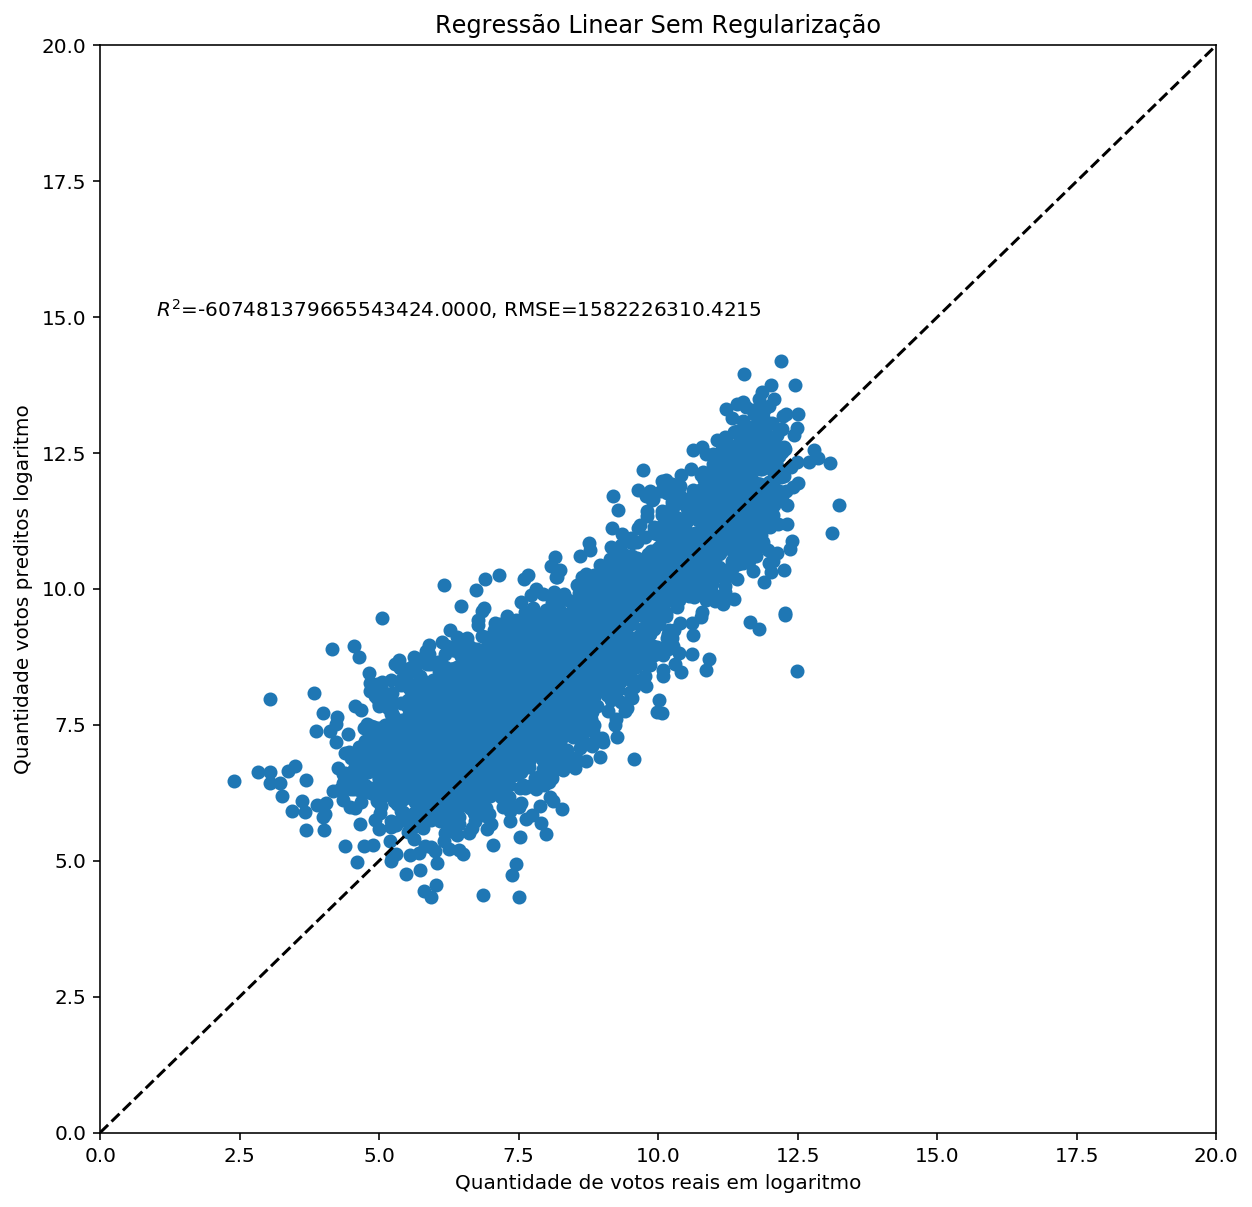

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, lmp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão Linear Sem Regularização')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, lmp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, lmp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.2 Regularização Ridge


Text(0, 0.5, 'rmse')

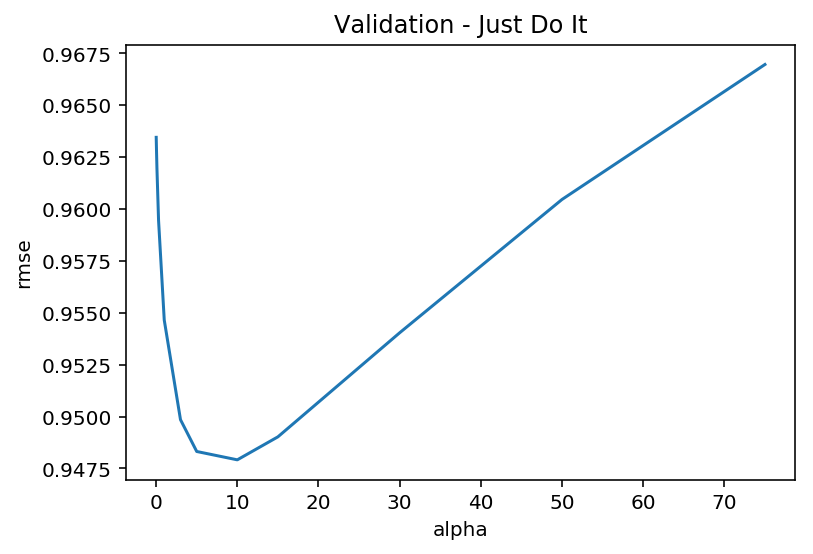

In [24]:
alphas = [0.01,0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),x_treino,y_treino).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")


In [25]:
# Criando o modelo com o alpha com menor rmse
rm = Ridge(alpha=10)

# Ajustando o modelo
rm.fit(x_treino,y_treino)

# Predição do conjunto teste 
rmp = rm.predict(x_teste)

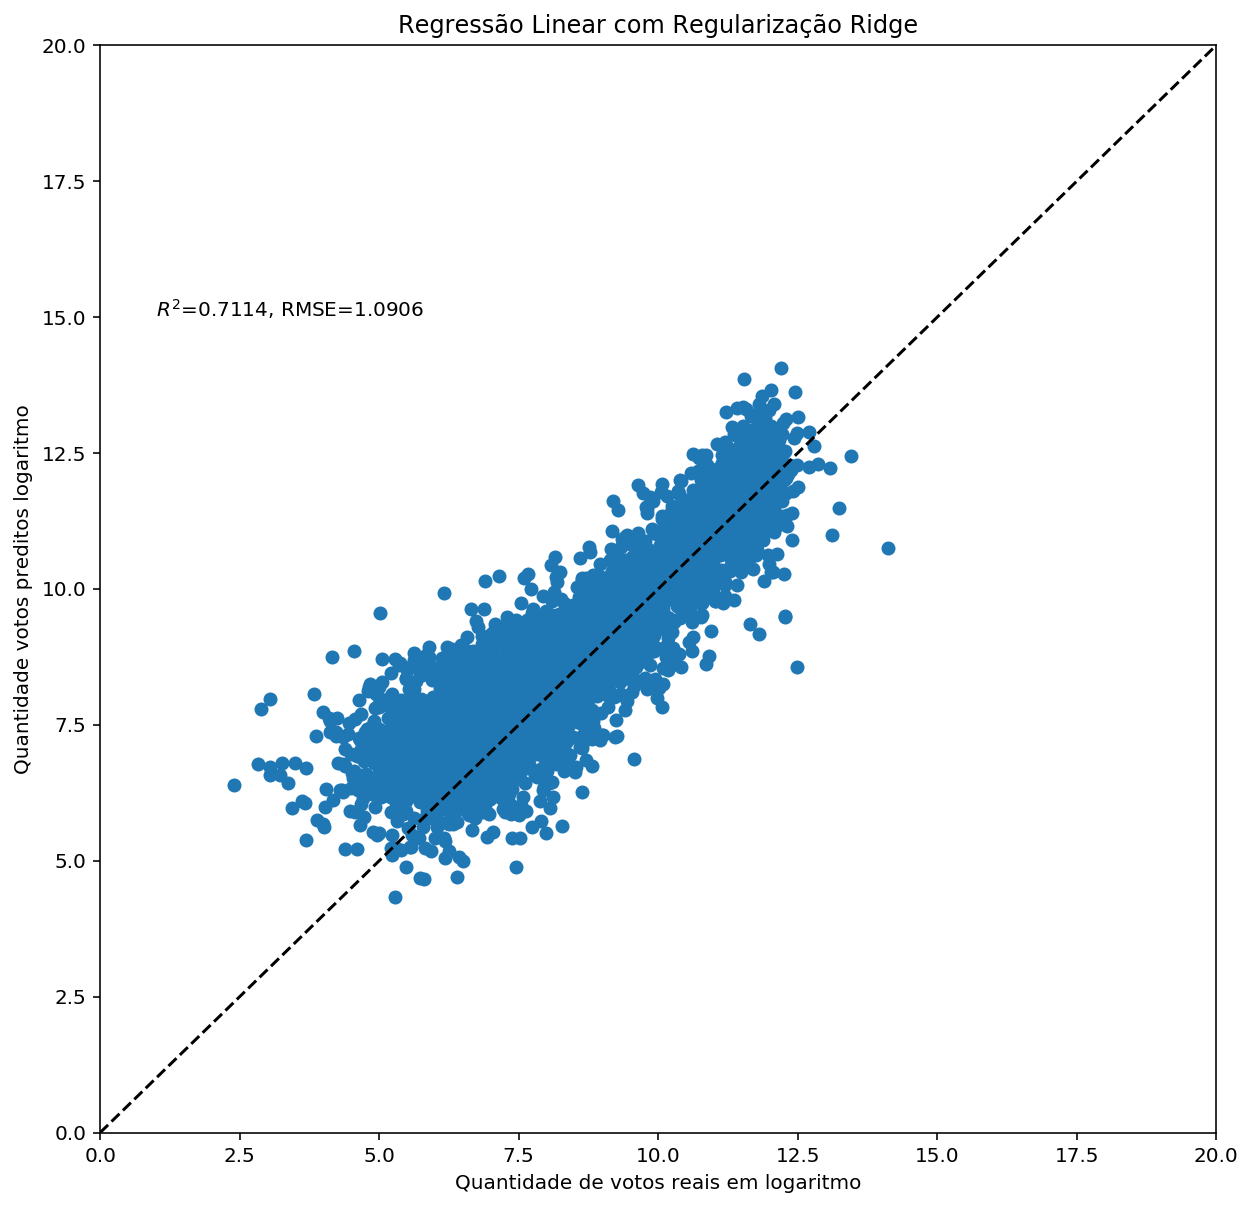

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, rmp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão Linear com Regularização Ridge')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, rmp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, rmp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.3 Regularização Lasso


In [27]:
#Pelo próprio construtor é definido o alpha ideal por validação cruzada e ajudatado o modelo pelos conjuntos de treino
lam = LassoCV(alphas = [0.01,0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(x_treino, y_treino)

# Predição do conjunto teste 
lamp = lam.predict(x_teste)

c:\users\eugênio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\eugênio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


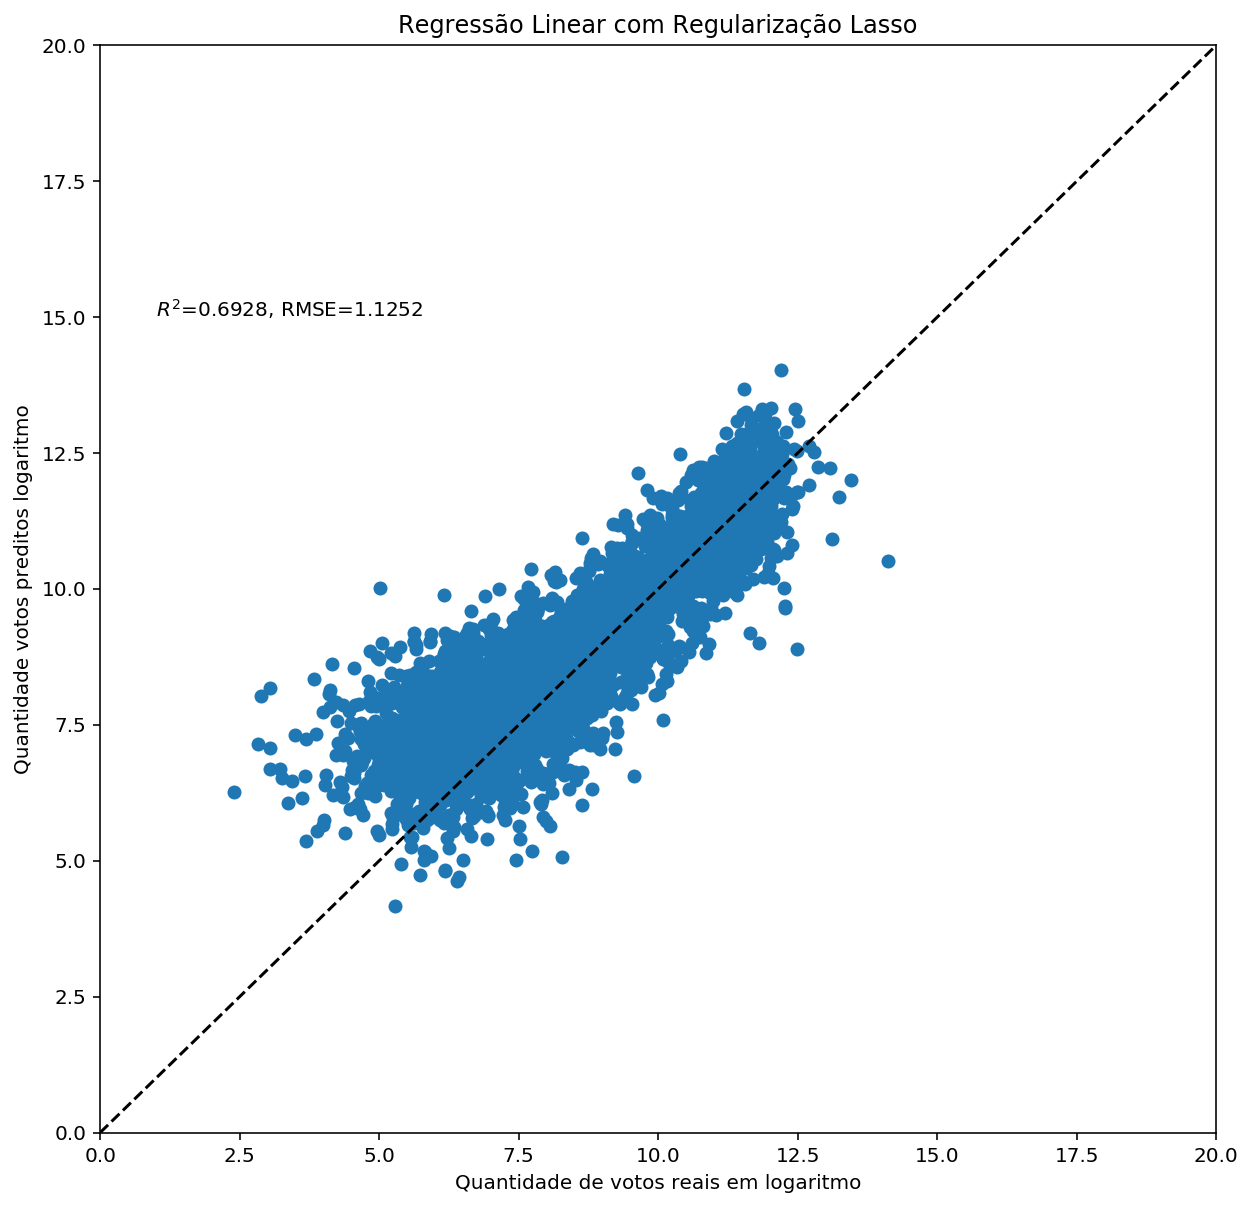

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, lamp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão Linear com Regularização Lasso')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, lamp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, lamp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.4 Regressão com KNN


In [29]:
# Criando o modelo
knnm = KNeighborsRegressor(n_neighbors=5,weights='uniform',p=2)

#Ajustando o modelo
knnm.fit(x_treino,y_treino)

#Predição do conjunto teste
knnmp = knnm.predict(x_teste)

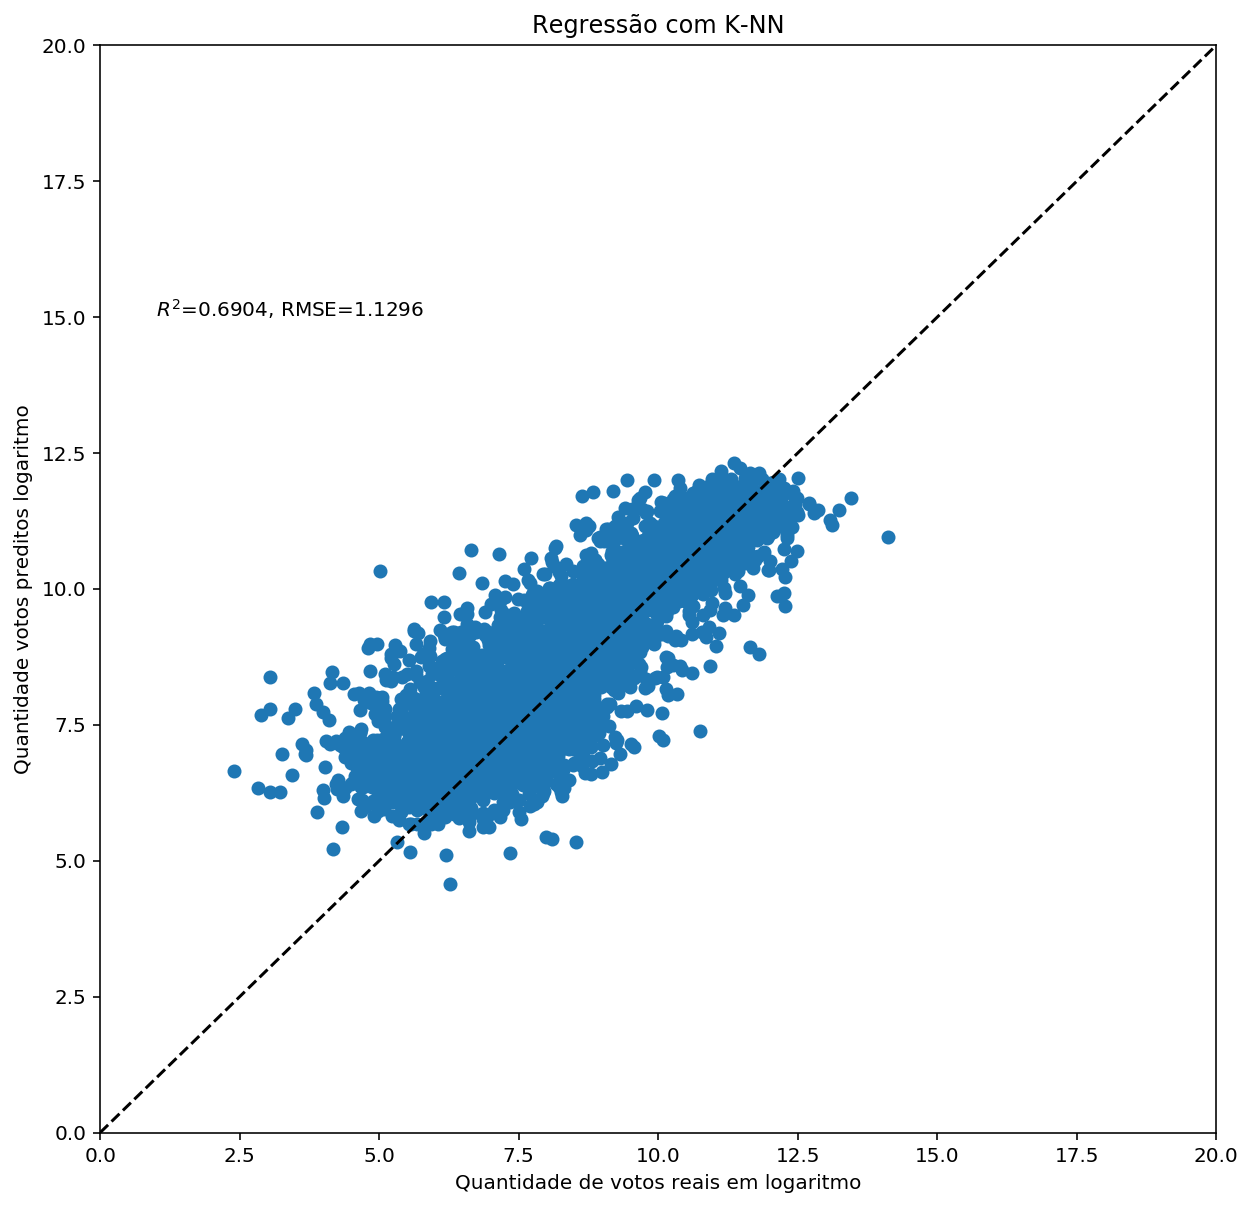

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, knnmp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão com K-NN')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, knnmp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, knnmp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.5 Regressão com SVR

In [31]:
#Criando o modelo
svrm = SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=1.0)

#Ajustando o modelo
svrm.fit(x_treino,y_treino)

#Predição do conjunto teste
svrmp = svrm.predict(x_teste)

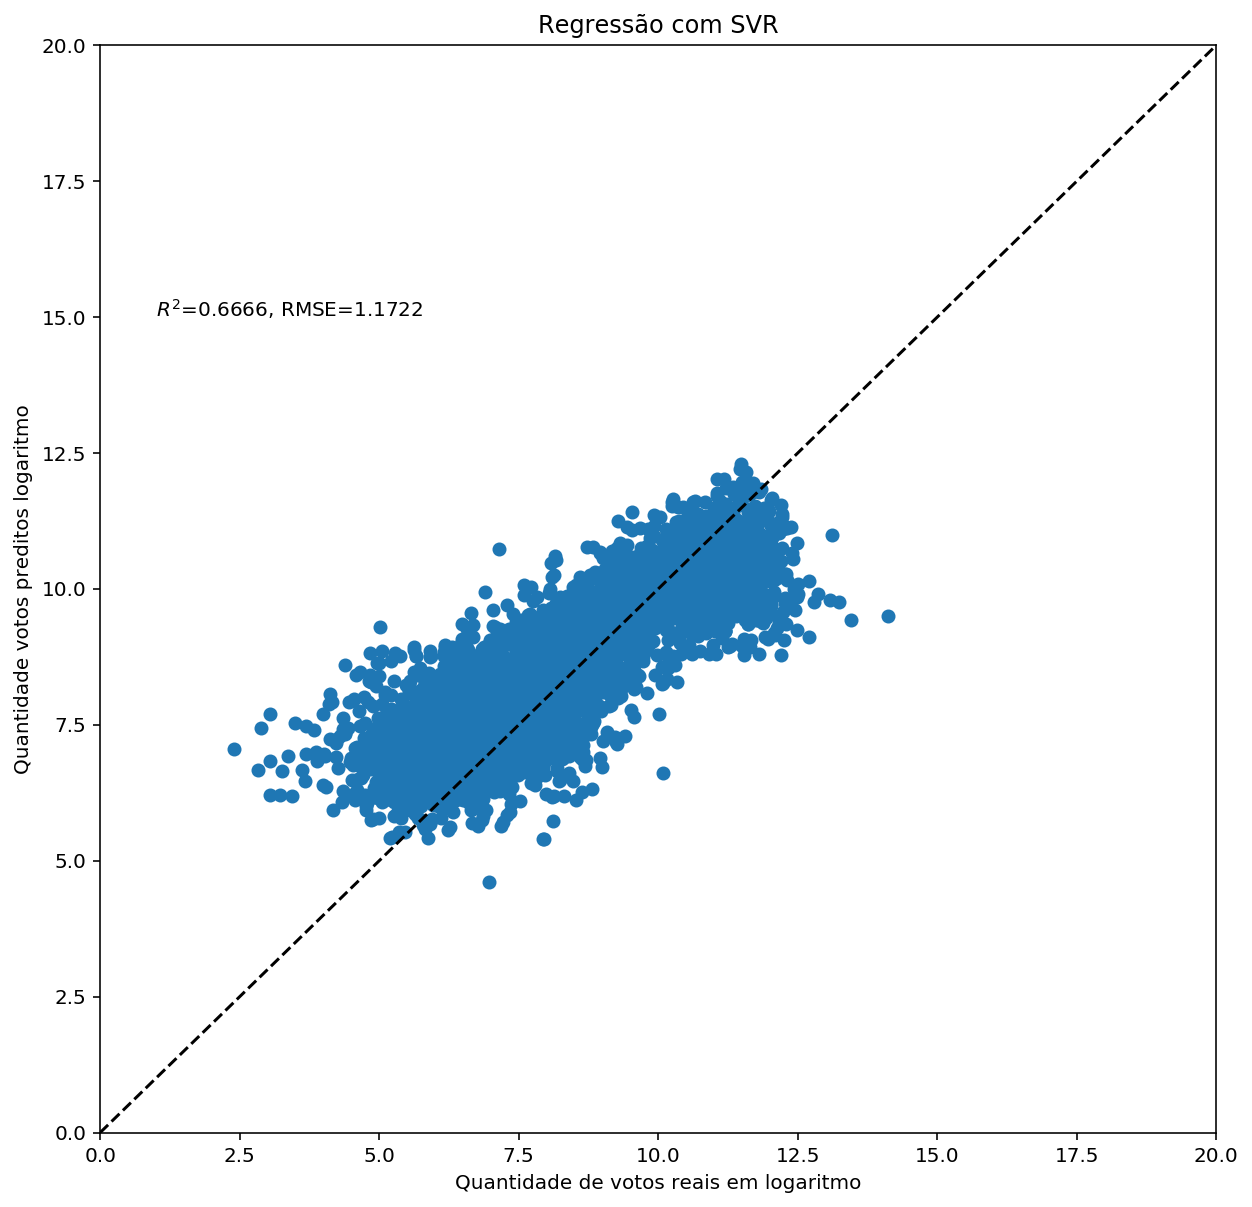

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, svrmp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão com SVR')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, svrmp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, svrmp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.6 Regressão com Árvores de Decisão

In [33]:
#Criando modelo
radm = DecisionTreeRegressor(criterion="mse",min_samples_leaf=10)

#Ajustando o modelo
radm.fit(x_treino,y_treino)

#Predição com o conjunto teste
radmp = radm.predict(x_teste)

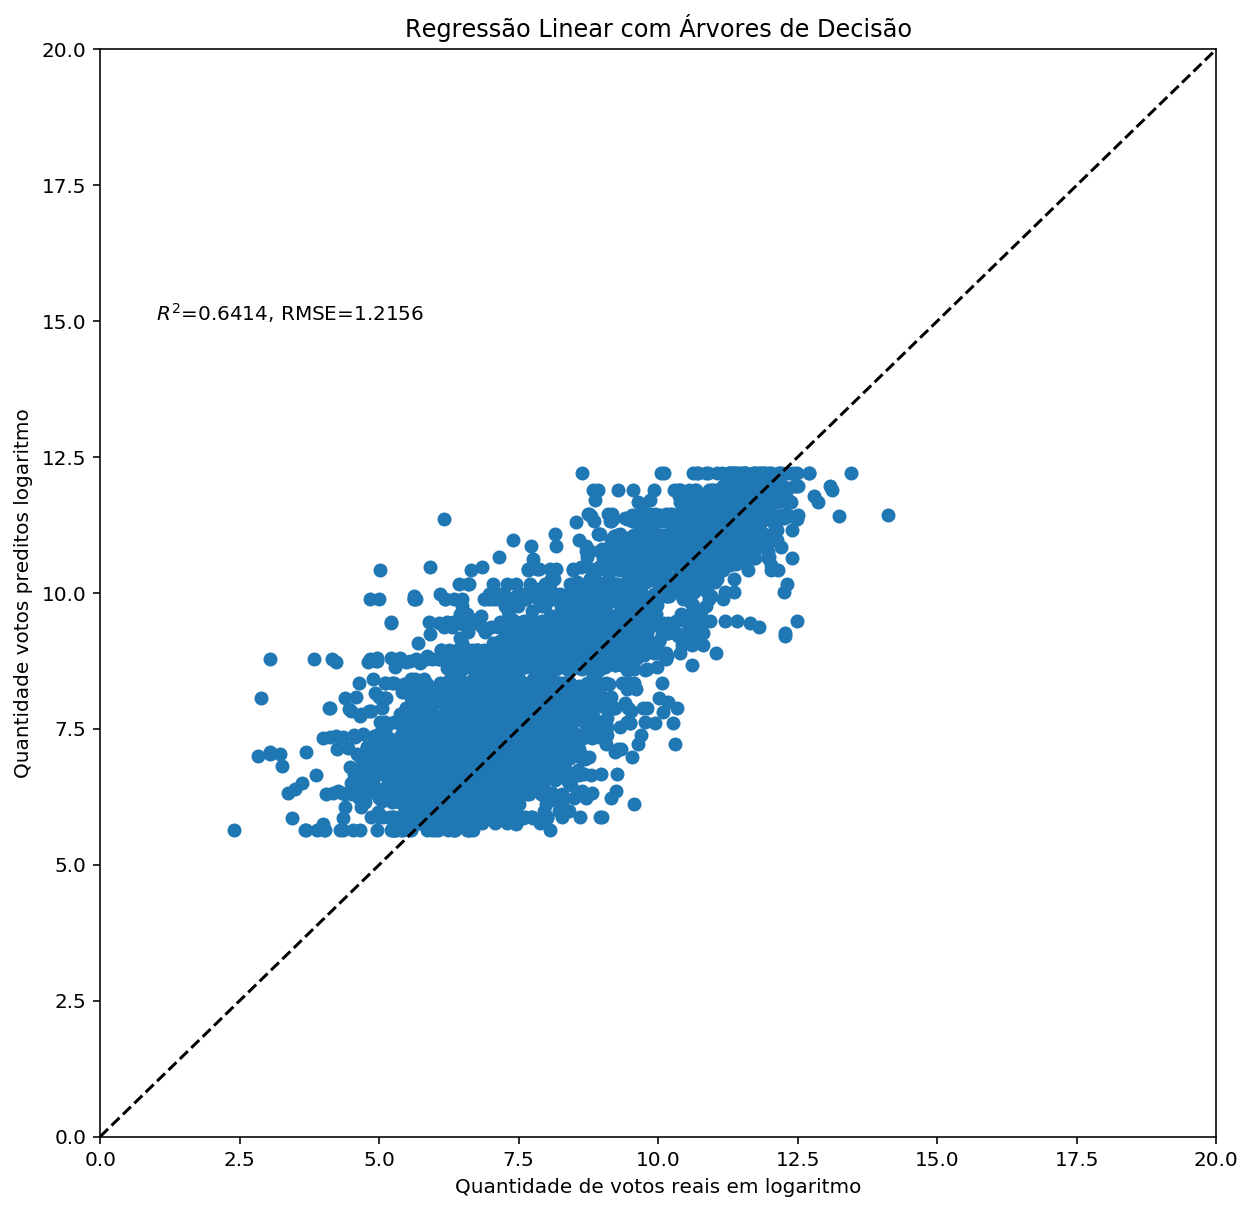

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, radmp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão Linear com Árvores de Decisão')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, radmp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, radmp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.7 Regressão com Florestas Aleatórias 

In [35]:
#criação do modelo
rfam = RandomForestRegressor(n_estimators = 10, random_state = 5)

#Ajustando o modelo
rfam.fit(x_treino,y_treino)

#Predição com o conjunto teste
rfamp = rfam.predict(x_teste)

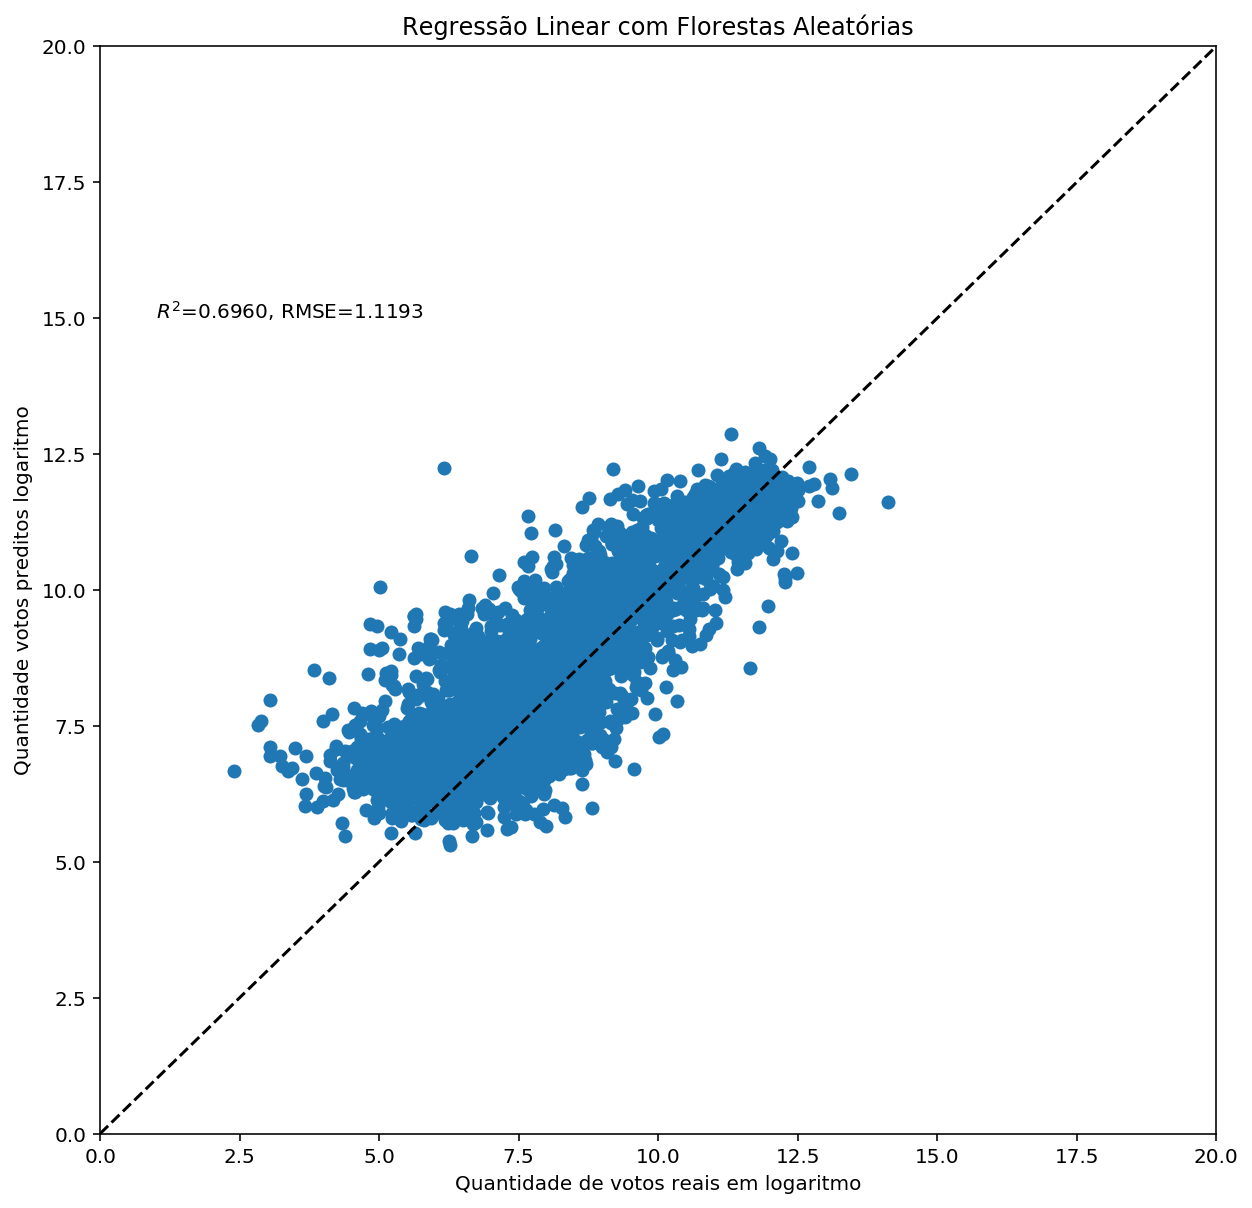

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y_teste, rfamp)
ax.plot([0, 100], [0, 100], '--k', c='black')
ax.set_ylabel('Quantidade votos preditos logaritmo')
ax.set_xlabel('Quantidade de votos reais em logaritmo')
ax.set_title('Regressão Linear com Florestas Aleatórias')
ax.text(1, 15, r'$R^2$=%.4f, RMSE=%.4f' % (metrics.r2_score(y_teste, rfamp), 
                                           np.sqrt(metrics.mean_squared_error(y_teste, rfamp))))
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

plt.show()

## 3.8 Utilização dos modelos em novo conjunto de teste (2014)

In [37]:
lmp = lm.predict(x_novoTeste)
print('RMSE Modelo Linear sem Regularização: ',np.sqrt(metrics.mean_squared_error(y_novoTeste, lmp)))

rmp = rm.predict(x_novoTeste)
print('RMSE Modelo Linear com Regularização Ridge: ', np.sqrt(metrics.mean_squared_error(y_novoTeste, rmp)))

lamp = lam.predict(x_novoTeste)
print('RMSE Modelo Linear com Regularização Lasso: ', np.sqrt(metrics.mean_squared_error(y_novoTeste, lamp)))

knnmp = knnm.predict(x_novoTeste)
print('RMSE Modelo KNN: ', np.sqrt(metrics.mean_squared_error(y_novoTeste, knnmp)))

svrmp = svrm.predict(x_novoTeste)
print('RMSE Modelo SVR: ', np.sqrt(metrics.mean_squared_error(y_novoTeste, svrmp)))

radmp = radm.predict(x_novoTeste)
print('RMSE Modelo Árvore de Decisão: ', np.sqrt(metrics.mean_squared_error(y_novoTeste, radmp)))

rfamp = rfam.predict(x_novoTeste)
print('RMSE Modelo Florestas Aleatórias: ', np.sqrt(metrics.mean_squared_error(y_novoTeste, rfamp)))

RMSE Modelo Linear sem Regularização:  1160312376.4322996
RMSE Modelo Linear com Regularização Ridge:  1.0041973453955308
RMSE Modelo Linear com Regularização Lasso:  1.0524057928198347
RMSE Modelo KNN:  0.9992035306217244
RMSE Modelo SVR:  0.9856960013611482
RMSE Modelo Árvore de Decisão:  1.0251371434284426
RMSE Modelo Florestas Aleatórias:  0.8644388242841531


#  4 Análise dos Resultados

De acordo com os valores da raiz quadrada da média dos erros quadrados da predição de cada modelo novo conjunto de teste eleicoes_2014.csv, o modelo que apresentou melhor resultado foi o de Florestas Aleatórias com RMSE = 0.86 (resultado em logaritmo).